In [20]:
import pandas as pd
import numpy as np
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Sequential

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
df.shape

(112475, 12)

### Preprocess dates

In [22]:
# Extract features from the date
df['day_of_week'] = pd.to_datetime(df['dteday']).dt.dayofweek
df['day'] = pd.to_datetime(df['dteday']).dt.day
df['month'] = pd.to_datetime(df['dteday']).dt.month

# One-hot encode the features
dow_encoder = OneHotEncoder()
day_encoder = OneHotEncoder()
month_encoder = OneHotEncoder()

dow_encoded = dow_encoder.fit_transform(df[['day_of_week']]).toarray()
day_encoded = day_encoder.fit_transform(df[['day']]).toarray()
month_encoded = month_encoder.fit_transform(df[['month']]).toarray()

dow_encoded = pd.DataFrame(dow_encoded, columns=[f'day_of_week_{i}' for i in range(7)])
day_encoded = pd.DataFrame(day_encoded, columns=[f'day_{i}' for i in range(1, 32)])
month_encoded = pd.DataFrame(month_encoded, columns=[f'month_{i}' for i in range(1, 13)])

# Concatenate the encoded features with the original dataframe
df_encoded = pd.concat([df, dow_encoded, day_encoded, month_encoded], axis=1)

# Drop the original features
df_encoded.drop(['dteday', 'day_of_week', 'day', 'month'], axis=1, inplace=True)

print(df_encoded.columns)

Index(['hr', 'casual', 'registered', 'temp_c', 'feels_like_c', 'hum',
       'windspeed', 'weathersit', 'season', 'holiday', 'workingday',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


### Create target column

In [23]:
df_encoded['total'] = df['casual'] + df['registered']
df_encoded.drop(['casual', 'registered'], inplace=True, axis=1)

df_encoded.head()

,hr,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday,day_of_week_0,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,total
0,0.0,3.0,3.0,0.7957,0.8,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,1.0,1.7,1.7,0.8272,0.8,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,2.0,1.9,1.9,0.8157,1.1,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31
3,3.0,2.5,2.5,0.7831,0.8,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
4,4.0,2.0,2.0,0.8075,1.1,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [24]:
y = df_encoded['total']
X = df_encoded.drop('total', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [25]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform data
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

### Make the model

In [26]:
# Tried:
# Model 1: 35000 MSE
# Dense(64, activation='sigmoid', input_dim=num_features),
# Dense(128, activation='sigmoid'),
# Dense(64, activation='sigmoid'),
# Dense(1, activation='swish')

# Model 2: 12719 MSE,
# Dense(128, activation='relu', input_dim=num_features),
# Dense(64, activation='relu'),
# Dense(32, activation='relu'),
# Dense(1)

# Model 3: 16359 MSE, 17664 MSE
# Dense(128, activation='relu', input_dim=num_features),
# BatchNormalization(),
# Dense(64, activation='relu'),
# BatchNormalization(),
# Dense(32, activation='relu'),
# BatchNormalization(),
# Dense(1)

# Model 4: Model MSE: 26334  Validation MSE: 157
# Dense(128, activation='relu', input_dim=num_features),
# Dropout(.4),
# Dense(64, activation='relu'),
# Dropout(.4),
# Dense(32, activation='relu'),
# Dense(1)

# Model 5: Model MSE:
# Dense(128, activation='relu', input_dim=num_features),
# BatchNormalization(),
# Dropout(.3),
# Dense(64, activation='relu'),
# BatchNormalization(),
# Dropout(.3),
# Dense(32, activation='relu'),
# Dense(1)

num_features = len(X_train[0])

model = Sequential([
  Dense(128, activation='relu', input_dim=num_features),
  BatchNormalization(),
  Dropout(.3),
  Dense(64, activation='relu'),
  BatchNormalization(),
  Dropout(.3),
  Dense(32, activation='relu'),
  Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           7,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,817 (73.50 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [27]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

opt = keras.optimizers.Adam(learning_rate=0.0004)
model.compile(loss='mse', optimizer=opt, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=15, mode='min')

history = model.fit(X_train, y_train, epochs=5, validation_split=.20, batch_size=25, callbacks=[early_stop], shuffle=False)
hist = pd.DataFrame(history.history)

Epoch 1/5
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 152470.0469 - mse: 152470.0469 - val_loss: 52941.7148 - val_mse: 52941.7148
Epoch 2/5
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 60803.2656 - mse: 60803.2656 - val_loss: 45660.7656 - val_mse: 45660.7656
Epoch 3/5
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 55176.1641 - mse: 55176.1641 - val_loss: 43188.4727 - val_mse: 43188.4727
Epoch 4/5
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 52230.1094 - mse: 52230.1094 - val_loss: 40579.8164 - val_mse: 40579.8164
Epoch 5/5
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 50581.4336 - mse: 50581.4336 - val_loss: 39046.6719 - val_mse: 39046.6719


### Plot loss

In [28]:
#px.line(hist, x='index', y='mse')

### Predict values

In [29]:
predictions = np.round(model.predict(X_test), 1)
predictions

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[211.3],
       [841.3],
       [383.5],
       ...,
       [512.3],
       [371.5],
       [225.8]], dtype=float32)

In [30]:
result = root_mean_squared_error(y_test, predictions)
result

203.40141546378155

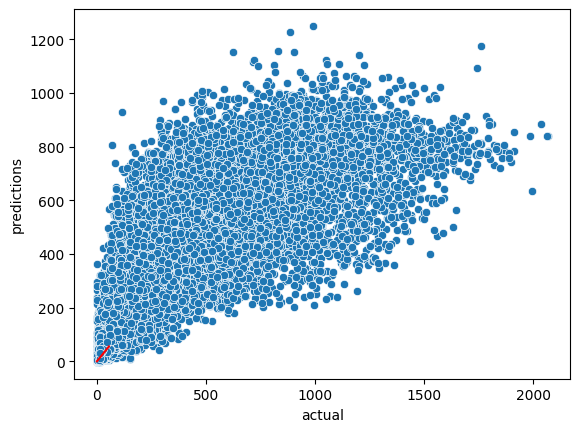

In [31]:
pred = pd.DataFrame(predictions,columns=['predictions'])
pred
pred['actual'] = y_test.tolist()
pred

pred['difference'] = pred['actual'] - pred['predictions']
pred

import seaborn as sns
import matplotlib.pyplot as plt

xlims =(0,55)
ax = sns.scatterplot(data=pred,x='actual',y='predictions')
ax.plot(xlims,xlims, color='r')
plt.show()

In [32]:
model.save('levi_model.keras')

### Predict mini holdout

In [33]:
mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv')

# Extract features from the date
mini['day_of_week'] = pd.to_datetime(mini['dteday']).dt.dayofweek
mini['day'] = pd.to_datetime(mini['dteday']).dt.day
mini['month'] = pd.to_datetime(mini['dteday']).dt.month

# One-hot encode the features
day_of_week_encoded = dow_encoder.transform(mini[['day_of_week']]).toarray()
day_encoded = day_encoder.transform(mini[['day']]).toarray()
month_encoded = month_encoder.transform(mini[['month']]).toarray()

# Concatenate the encoded features with the original dataframe
mini_encoded = pd.concat([
                mini,
                pd.DataFrame(day_of_week_encoded, columns=[f'day_of_week_{i}' for i in range(7)]),
                pd.DataFrame(day_encoded, columns=[f'day_{i}' for i in range(1, 32)]),
                pd.DataFrame(month_encoded, columns=[f'month_{i}' for i in range(1, 13)])
              ], axis=1)

# Drop the original features
mini_encoded.drop(['dteday', 'day_of_week', 'day', 'month'], axis=1, inplace=True)

print(mini_encoded.columns)

# transform data
mini_encoded = norm.transform(mini_encoded)

mini_pred = np.round(model.predict(mini_encoded), 1)

mini_pred = pd.DataFrame(mini_pred, columns = ['predictions'])
mini_pred.to_csv("levi-predictions.csv", index=False)

Index(['hr', 'temp_c', 'feels_like_c', 'hum', 'windspeed', 'weathersit',
       'season', 'holiday', 'workingday', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30', 'day_31', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
